In [1]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
import torch.utils.data as data_utils
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from sklearn.model_selection import train_test_split
import sklearn.datasets as datasets
import pySODE
import torchdiffeq

In [2]:
import ipyexperiments
import timeit
import time

In [3]:
torch.cuda.manual_seed_all(2)

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Defining linear ODE model

In [5]:
class GenericModel(object):
    def __init__(self, F, numpy=True):
        if numpy: self.F = F.numpy()
        else: self.F = F
        self.numpy = numpy
    def __call__(self, dt, x):
        if self.numpy: return np.matmul(self.F, x)
        else: return torch.matmul(self.F, x)

In [6]:
class SparseModel(GenericModel):
    def __init__(self, F, numpy=True):
        super().__init__(F, numpy)
    def __call__(self, dt, x):
        return self.F[0][0]*x

In [7]:
F_orig = -0.5*torch.eye(1)
x_orig = 20*torch.rand(100000)
m = GenericModel(F_orig)

## Creating dataset

In [44]:
data = 'spirals'

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.002
･ CPU:          0          0      2,173 MB |
･ GPU:          9          0      1,732 MB |


In [45]:
def twospirals(n_points, noise=.5):
    """
     Returns the two spirals dataset.
    """
    n = np.sqrt(np.random.rand(n_points,1)) * 780 * (2*np.pi)/360
    d1x = -np.cos(n)*n + np.random.rand(n_points,1) * noise
    d1y = np.sin(n)*n + np.random.rand(n_points,1) * noise
    return (np.vstack((np.hstack((d1x,d1y)),np.hstack((-d1x,-d1y)))), 
            np.hstack((np.zeros(n_points),np.ones(n_points))))

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.007
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


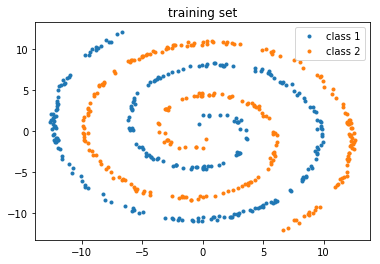

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.168
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


In [46]:
if data == 'blobs':
    X,yn = datasets.make_blobs(n_samples=256, centers = 2,n_features=2, cluster_std=4)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'moons':
    X, yn = datasets.make_moons(n_samples=10)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
if data == 'mclass':
    X, yn = datasets.make_classification(n_samples=500,n_informative=4,n_clusters_per_class=3,n_classes=3)
    plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
    plt.scatter(X[yn==0,0],X[yn==0,1],color='red')
    plt.scatter(X[yn==2,0],X[yn==2,1],color='green')
if data == 'spirals':
    X, yn = twospirals(256)
    plt.title('training set')
    plt.plot(X[yn==0,0], X[yn==0,1], '.', label='class 1')
    plt.plot(X[yn==1,0], X[yn==1,1], '.', label='class 2')
    plt.legend()

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, yn, test_size=0.5)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.004
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


In [48]:
# choose batch size here
bs = 32

X_train = torch.Tensor(X_train).to(device)
y_train = torch.LongTensor(y_train).to(device)
X_test = torch.Tensor(X_test).to(device)
y_test = torch.LongTensor(y_test).to(device)

train = data_utils.TensorDataset(X_train,y_train)
trainloader = data_utils.DataLoader(train, batch_size=bs, shuffle=True)

test = data_utils.TensorDataset(X_test,y_test)
testloader = data_utils.DataLoader(test, batch_size=bs, shuffle=True)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.010
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


# Neural Network definition

In [49]:
class MLP(nn.Module):
    def __init__(self, dense_layers, softmax = True):
        '''
        Simple dense MLP class used as predictor
        
        :smax_l: leave True for softmax applied to ouput
        '''
        super().__init__()
        self.dense_layers = nn.ModuleList([nn.Linear(dense_layers[i], dense_layers[i + 1]) \
                                           for i in range(len(dense_layers) - 1)])
        self.softmax = softmax
        
    def getLength(self):
        return len(self.dense_layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        for l in self.dense_layers:
            l_x = l(x)
            x = F.relu(l_x)
        if not self.softmax: return l_x
        else: return F.log_softmax(l_x, dim=-1)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.009
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


# Training

In [18]:
exp1 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3011 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,150   6,535  15,960 MB  13.47% 
GPU:   1,716   1,294   3,011 MB  57.01% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.075
･ CPU:          0          0      2,150 MB |
･ GPU:          0          0      1,716 MB |

IPyExperimentsPytorch: Finishing

*** Experiment finished in 00:00:32 (elapsed wallclock time)

*** Newly defined local variables:
Deleted: criterion, d, dataiter, dt, epochs, i, idx, ode_steps, optimizer, x, y
Failed to delete: e, j

*** Experiment memory:
RAM: Consumed       Reclaimed
CPU:      183        0 MB (  0.00%)
GPU:       33        0 MB (  0.00%)

*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,150   6,535  15,960 MB  13.47% 
GPU:   1,716   1,294   3,011 MB  57.01% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.052
･ CPU:          0          0   

In [34]:
m = MLP([2, 10, 10, 2]).cuda()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.007
･ CPU:          0          0      2,170 MB |
･ GPU:          0          0      1,720 MB |


In [35]:
criterion = F.nll_loss
optimizer = torch.optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
epochs = 100
dt = 0.01 
ode_steps = 1

for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m(x), y)
            loss.backward()
            with torch.no_grad():
                for p in m.parameters():
                    n = torch.numel(p)
                    p = pySODE.ode_solve(-torch.eye(n).cuda(), p.view(-1), p.grad.view(-1), dt, 1, n, 'Euler')
        m.zero_grad()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.394
･ CPU:          0          0      2,171 MB |
･ GPU:          0          0      1,720 MB |


In [ ]:
del exp1

In [50]:
exp2 = ipyexperiments.IPyExperimentsPytorch()


*** Experiment started with the Pytorch backend
Device: ID 0, GeForce GTX 1060 3GB (3011 RAM)


*** Current state:
RAM:    Used    Free   Total       Util
CPU:   2,173   6,485  15,960 MB  13.62% 
GPU:   1,732   1,278   3,011 MB  57.54% 


･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.069
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.025
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,732 MB |


In [58]:
m = MLP([2, 10000, 1000, 1000, 100, 2]).cuda()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.120
･ CPU:          0          0      2,182 MB |
･ GPU:          0         40      1,784 MB |
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.150
･ CPU:          0          0      2,182 MB |
･ GPU:          0         40      1,784 MB |


In [59]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

count_parameters(m)

11132302

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.003
･ CPU:          0          0      2,182 MB |
･ GPU:          0          0      1,784 MB |
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.043
･ CPU:          0          0      2,182 MB |
･ GPU:          0          0      1,784 MB |


In [60]:
criterion = F.nll_loss
optimizer = torch.optim.SGD(m.parameters(), lr=0.01, momentum=0.9)
epochs = 10
dt = 0.01 
ode_steps = 1

for e in range(epochs):
    dataiter = iter(trainloader)

    for i, d in enumerate(dataiter):
        x, y = next(dataiter)
        x, y = x.cuda(), y.cuda()
        for j in range(ode_steps):
            loss = criterion(m(x), y)
            loss.backward()
            with torch.no_grad():
                for p in m.parameters():
                    n = torch.numel(p)
                    p = pySODE.ode_solve(-torch.eye(n).cuda(), p.view(-1), p.grad.view(-1), dt, 1, n, 'Euler')
        m.zero_grad()

RuntimeError: CUDA out of memory. Tried to allocate 1.49 GiB (GPU 0; 2.94 GiB total capacity; 88.71 MiB already allocated; 1.16 GiB free; 19.29 MiB cached)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.242
･ CPU:          0          0      2,182 MB |
･ GPU:         40          0      1,824 MB |
･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.283
･ CPU:          0          0      2,182 MB |
･ GPU:         40          0      1,824 MB |


In [ ]:
del exp2

# Boundary plot

In [36]:
def genpoints(xmin,xmax,ymin,ymax,number_points):
    xx = torch.linspace(xmin,xmax,number_points)
    yy = torch.linspace(ymin,ymax,number_points)
    c = 1
    P = []
    for i in range(number_points):
        for j in range(number_points):
            P.append([xx[i],yy[j]])
    return torch.Tensor(P).cuda()

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.007
･ CPU:          0          0      2,171 MB |
･ GPU:          0          0      1,720 MB |


In [40]:
mp = genpoints(-20,25,-20,25,100)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.075
･ CPU:          0          2      2,172 MB |
･ GPU:          0          0      1,720 MB |


In [41]:
mp.shape

torch.Size([10000, 2])

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.004
･ CPU:          0          0      2,172 MB |
･ GPU:          0          0      1,720 MB |


In [42]:
y, idx = torch.max(torch.exp(m.forward(mp)), 1)

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.007
･ CPU:          0          0      2,172 MB |
･ GPU:          2          0      1,722 MB |


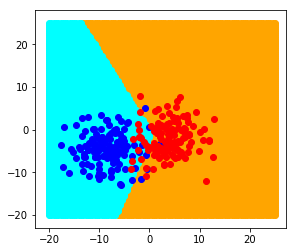

･ RAM:  △Consumed    △Peaked    Used Total | Exec time 0:00:00.282
･ CPU:          0          0      2,173 MB |
･ GPU:          0          0      1,722 MB |


In [43]:
mp_r = mp[idx==0]
mp_b = mp[idx==1]
plt.figure(figsize=(4.5,4))
plt.scatter(mp_r[:,0].cpu(),mp_r[:,1].cpu(),color='orange')
plt.scatter(mp_b[:,0].cpu(),mp_b[:,1].cpu(),color='cyan')
plt.scatter(X[yn==1,0],X[yn==1,1],color='blue')
plt.scatter(X[yn==0,0],X[yn==0,1],color='red')